In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 

import matplotlib.pyplot as plt
from importlib import reload

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from category_encoders.count import CountEncoder

import plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
%matplotlib inline 
pd.set_option('display.max_columns',500)

In [2]:
df = pd.read_csv('games.csv')

In [3]:
df.head()

id  rated    created_at  last_move_at  turns victory_status winner  \
0  TZJHLljE  False  1.504210e+12  1.504210e+12     13      outoftime  white   
1  l1NXvwaE   True  1.504130e+12  1.504130e+12     16         resign  black   
2  mIICvQHh   True  1.504130e+12  1.504130e+12     61           mate  white   
3  kWKvrqYL   True  1.504110e+12  1.504110e+12     61           mate  white   
4  9tXo1AUZ   True  1.504030e+12  1.504030e+12     95           mate  white   

  increment_code       white_id  white_rating      black_id  black_rating  \
0           15+2       bourgris          1500          a-00          1191   
1           5+10           a-00          1322     skinnerua          1261   
2           5+10         ischia          1496          a-00          1500   
3           20+0  daniamurashov          1439  adivanov2009          1454   
4           30+3      nik221107          1523  adivanov2009          1469   

                                               moves opening_eco  \
0  d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...         D10   
1  d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...         B00   
2  e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...         C20   
3  d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...         D02   
4  e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...         C41   

                             opening_name  opening_ply  
0        Slav Defense: Exchange Variation            5  
1  Nimzowitsch Defense: Kennedy Variation            4  
2   King's Pawn Game: Leonardis Variation            3  
3  Queen's Pawn Game: Zukertort Variation            3  
4                        Philidor Defense            5

# STATISTICAL ANALYSIS

#### Before Going for Statistical exploration of data, first check integrity of data & Missing value

## Data Integrity Check

In [4]:
df.duplicated().sum()  # This will check the duplicate data for all columns.

429

We have to drop duplicate

In [5]:
df = df.drop_duplicates()

In [6]:
df.duplicated().sum() #check again

0

In [7]:
df.columns.to_series().groupby(df.dtypes).groups #sort columns by datatype

{bool: ['rated'], int64: ['turns', 'white_rating', 'black_rating', 'opening_ply'], float64: ['created_at', 'last_move_at'], object: ['id', 'victory_status', 'winner', 'increment_code', 'white_id', 'black_id', 'moves', 'opening_eco', 'opening_name']}

## Missing value check

<Axes: >

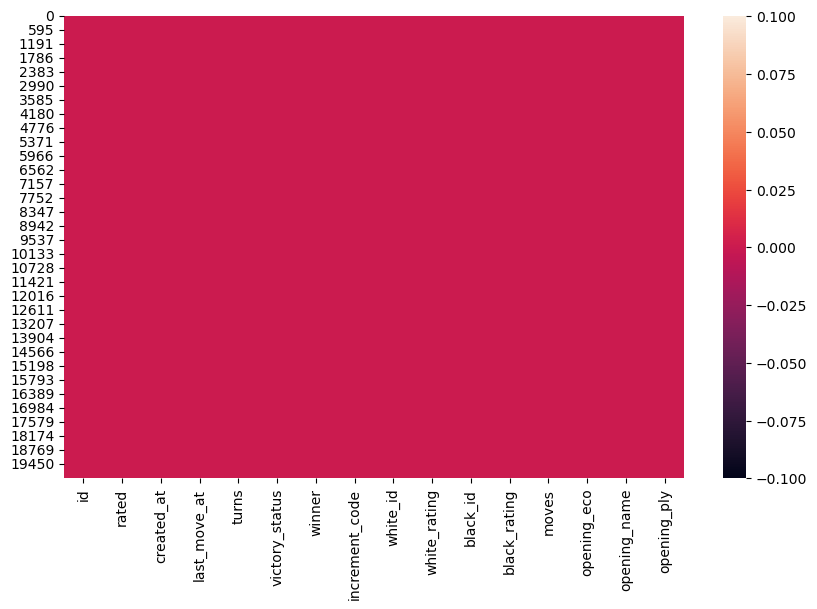

In [8]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull())

No missing data

## Statistical Matrix

In [9]:
df.describe().T

count          mean           std           min           25%  \
created_at    19629.0  1.483721e+12  2.809364e+10  1.376772e+12  1.477530e+12   
last_move_at  19629.0  1.483722e+12  2.809353e+10  1.376772e+12  1.477530e+12   
turns         19629.0  6.045861e+01  3.350285e+01  1.000000e+00  3.700000e+01   
white_rating  19629.0  1.596090e+03  2.901650e+02  7.840000e+02  1.400000e+03   
black_rating  19629.0  1.588325e+03  2.901644e+02  7.890000e+02  1.393000e+03   
opening_ply   19629.0  4.804422e+00  2.792791e+00  1.000000e+00  3.000000e+00   

                       50%           75%           max  
created_at    1.495830e+12  1.503107e+12  1.504493e+12  
last_move_at  1.495830e+12  1.503110e+12  1.504494e+12  
turns         5.500000e+01  7.900000e+01  3.490000e+02  
white_rating  1.567000e+03  1.791000e+03  2.700000e+03  
black_rating  1.562000e+03  1.783000e+03  2.723000e+03  
opening_ply   4.000000e+00  6.000000e+00  2.800000e+01

#### Observation:
- The lowest and the highest number of turn is 1 and 349 respectively, average at 55 moves
- The minimum rating of White is 784 while the maximum is 2723, the average is 1567
- The weakest Black elo is 789 while the strongest is 2723, average at 1562

# EDEA

## DISTRIBUTION OF WINNER

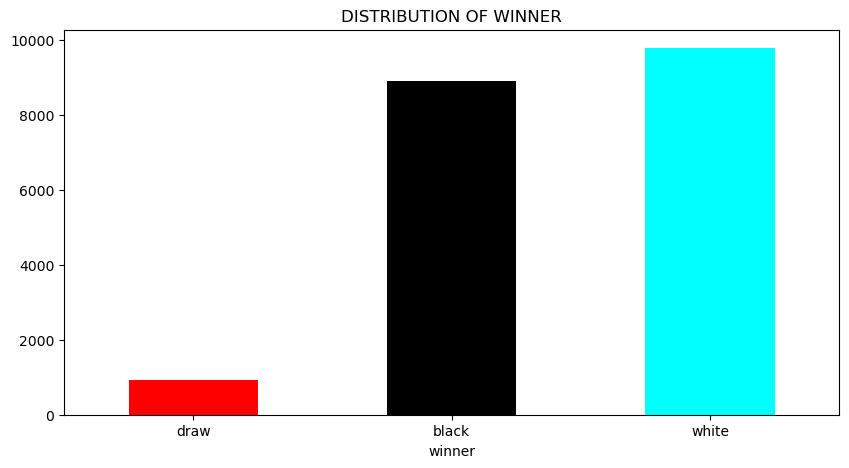

In [10]:
fig, ax = plt.subplots(figsize = (10,5))
pd.concat([df['winner']]).value_counts(ascending = True) \
    .plot(kind='bar',ax = ax, title = 'DISTRIBUTION OF WINNER', color = {'red','black','cyan'})
plt.xticks(rotation=0)
plt.show()

#### Obervation: 
- Have almost equal destribution between black and white 
- Very small games ended up in a draw

## DISTRIBUTION OF SKILL LEVEL

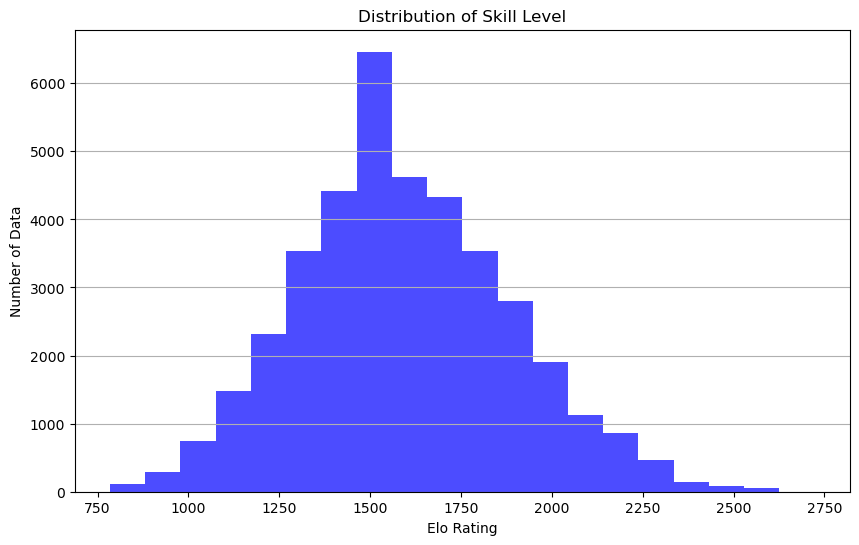

In [11]:
plt=reload(plt)
elo_ratings = df[['white_rating', 'black_rating']].stack()

# Create a histogram to visualize the Elo rating distribution
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.hist(elo_ratings, bins=20, color='blue', alpha=0.7)

# Add labels and title
plt.title("Distribution of Skill Level")
plt.xlabel("Elo Rating")
plt.ylabel("Number of Data")

# Show the graph
plt.grid(axis='y')
plt.show()

#### Obervation: 
- Most games are in the range of 1250 and 2000
- Rarely seen below 1250 and over 2000

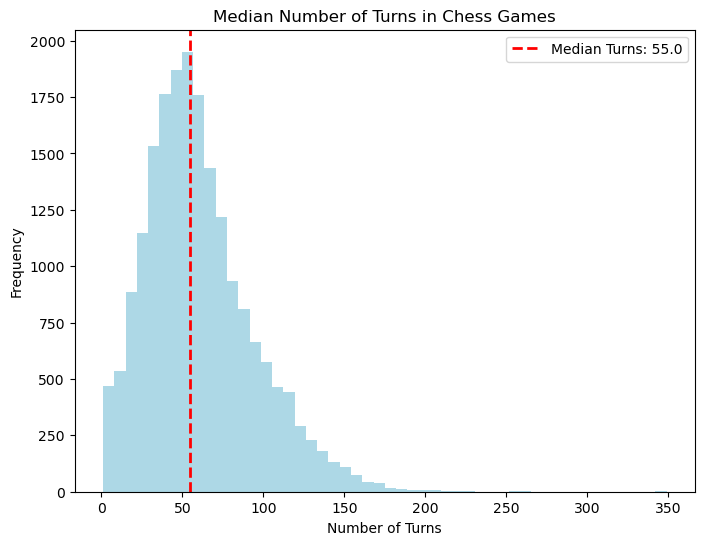

In [12]:
# Calculate the median number of turns
median_turns = df['turns'].median()

# Plot the median number of turns
plt.figure(figsize=(8, 6))
plt.hist(df['turns'], bins=50, color='lightblue')
plt.axvline(median_turns, color='red', linestyle='dashed', linewidth=2, label=f'Median Turns: {median_turns}')
plt.title('Median Number of Turns in Chess Games')
plt.xlabel('Number of Turns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#### Observation:
- The graph is skewed to the left and the median turns equal to 58 moves
- The higher the the turn get, the less games they have
- At 150th turn and go on, the frequency is at the 2-digit number to none

## DISTRUBUTION OF RATED GAME

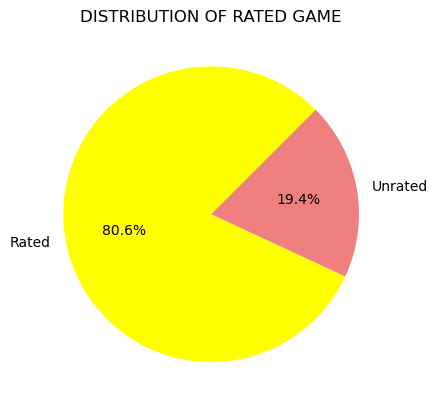

<Figure size 600x600 with 0 Axes>

In [13]:
plt=reload(plt)
plt.pie(df['rated'].value_counts(), labels=['Rated', 'Unrated'], colors=['yellow', 'lightcoral'], autopct='%1.1f%%', startangle=45)
plt.title('DISTRIBUTION OF RATED GAME')
plt.figure(figsize=(6, 6))
plt.show()

#### Observation: 
The Rated games are four times the Unrated ones


In [14]:
# Calculate time_control

def time_control(df):
    
    time_control = [int(x) for x in df['increment_code'].split('+')]
    
    return time_control[0] + np.floor((time_control[1] * df['turns']/2) / 60)
   

df['time_control'] = df.apply(time_control, axis=1)

C:\Users\khois\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



(0.0, 50.0)

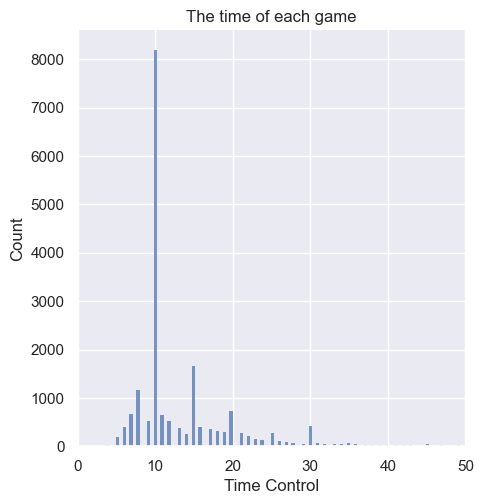

In [15]:
plt=reload(plt)
sns.set_theme()
sns.displot(df['time_control'])
plt.title('The time of each game')
plt.xlabel('Time Control')
plt.xlim(0, 50)

#### Observation:
- We see peaks at 10, 15, 20, and 30 minutes. Most games are blitz or rapid chess.

## FINDING THE MOST FREQUENT PLAYER ID IN THE ARCHIVE

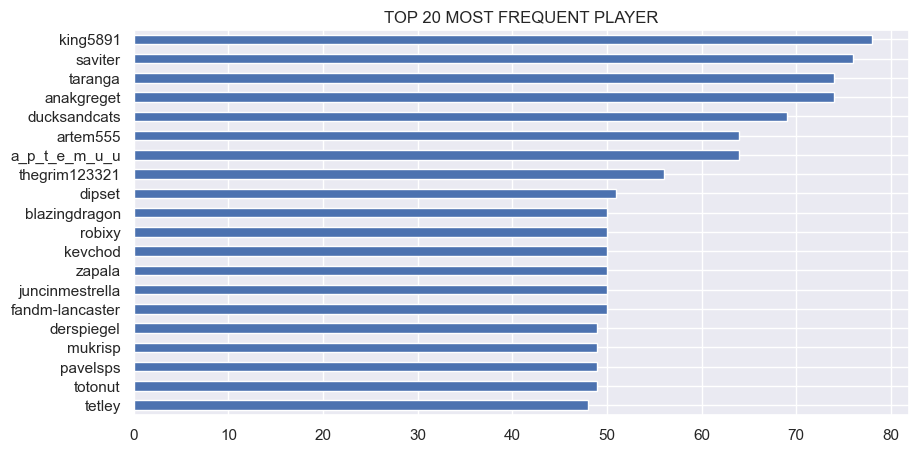

In [16]:
fig, ax = plt.subplots(figsize = (10,5))
pd.concat([df['white_id'], df['black_id']]).value_counts(ascending = True).tail(20) \
    .plot(kind='barh',ax = ax, title = 'TOP 20 MOST FREQUENT PLAYER')
plt.show()


## TOP 30 PERSON HAVE HIGHEST ELO

In [17]:
# Merge the 'White ID' and 'Black ID' columns into a single 'Player ID' column
df['Player_ID'] = df['white_id'].combine_first(df['black_id'])

# Calculate the highest Elo rating for each player
highest_elo_ratings = df.groupby('Player_ID')[['white_rating', 'black_rating']].max().max(axis=1)

# Sort players by their highest Elo rating
sorted_players = highest_elo_ratings.sort_values(ascending=True)

# Select the top 30 players
top_30_players = sorted_players.tail(30)


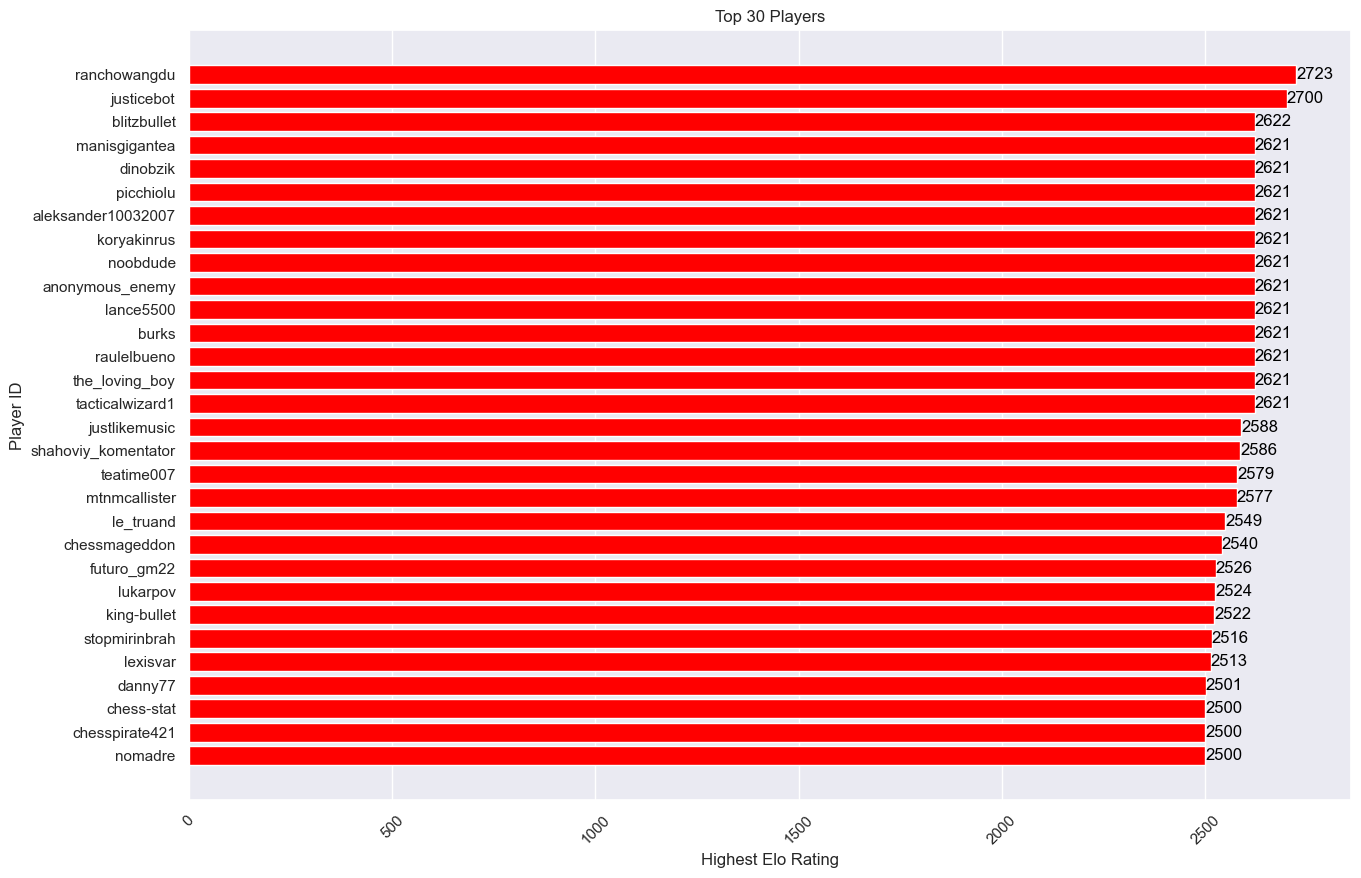

In [18]:
# Create a bar graph
plt=reload(plt)
plt.figure(figsize=(15, 10))
bars = plt.barh(top_30_players.index, top_30_players.values, color='red')
plt.title("Top 30 Players")

# Showing detail rating
for bar, elo in zip(bars, top_30_players.values):
    plt.text(elo, bar.get_y() + bar.get_height() / 2, f'{elo:.0f}', ha='left', va='center', color='black')

plt.xlabel("Highest Elo Rating")
plt.ylabel("Player ID")
plt.xticks(rotation=45)
plt.grid(axis='y')



# Show the graph
plt.show()

## TOP 10 CHESS OPENING

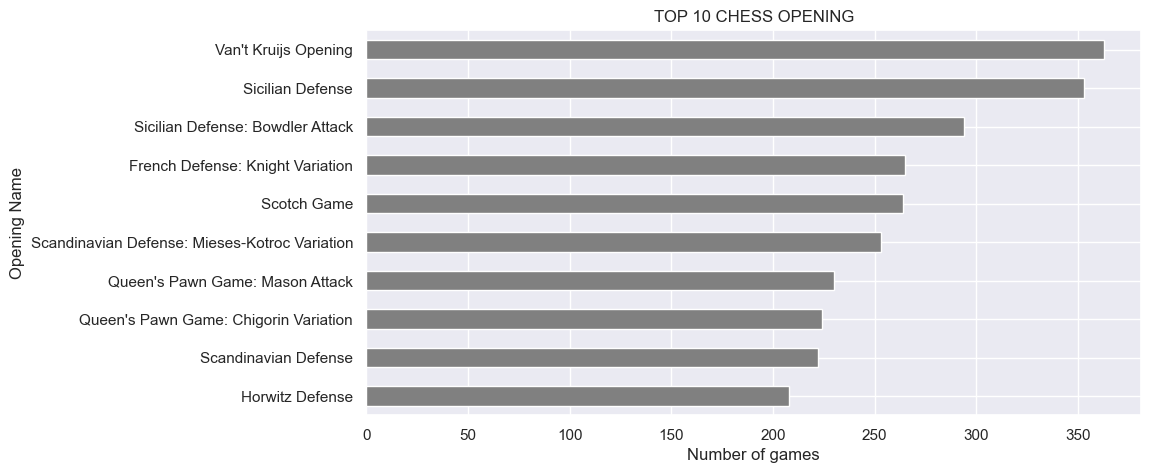

In [19]:
fig, ax = plt.subplots(figsize = (10,5))
pd.concat([df['opening_name']]).value_counts(ascending = True).tail(10) \
    .plot(kind='barh',ax = ax, title = 'TOP 10 CHESS OPENING', color= 'gray',xlabel = 'Number of games' , ylabel = 'Opening Name')
plt.show()


### Observation:
- Van't Krujis Opening is highest with about 365 matches, beacause of its suprise value and flexible play
- Follow up by the normal Silican Defense by 350 games.
- We can see many type of Defense like Sicilian, French, Scandinavian and Horwitz Defense, as well as 2 variation of Queen's Pawn game

## Find The Upset (Lower Rating Win the Higher Rating) 

In [20]:
df['EloDiff'] = df['black_rating'] - df['white_rating']

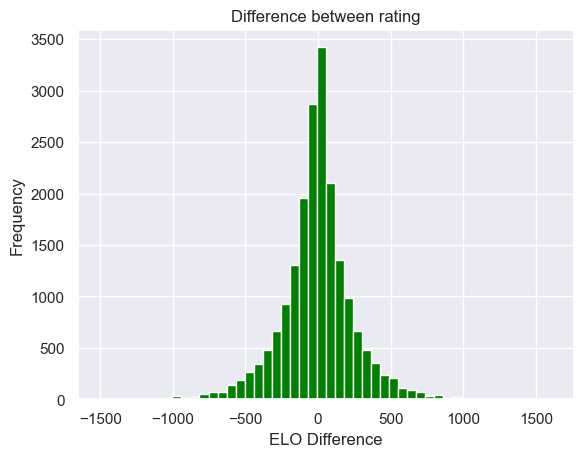

In [21]:
ax = df["EloDiff"].plot(kind = "hist", bins=50, title = "Difference between rating", color = 'green')
ax.set_xlabel("ELO Difference")
plt.show()

### Observation:
The Plot is symmetric, Black and White usually get matched at around the same level

In [22]:
df[['black_rating','white_rating','EloDiff','winner']]

black_rating  white_rating  EloDiff winner
0              1191          1500     -309  white
1              1261          1322      -61  black
2              1500          1496        4  white
3              1454          1439       15  white
4              1469          1523      -54  white
...             ...           ...      ...    ...
20053          1220          1691     -471  white
20054          1196          1233      -37  black
20055          1286          1219       67  white
20056          1227          1360     -133  white
20057          1339          1235      104  black

[19629 rows x 4 columns]

In [23]:
df['WhiteIsRatedHigher'] = df['white_rating'] > df['black_rating']

In [24]:
df_upsets = (
    df.query(
        "(WhiteIsRatedHigher and winner == 'white') or (not WhiteIsRatedHigher and winner == 'black')" 
    )
    .reset_index(drop=True)
)

Text(0.5, 0, 'ELO Difference')

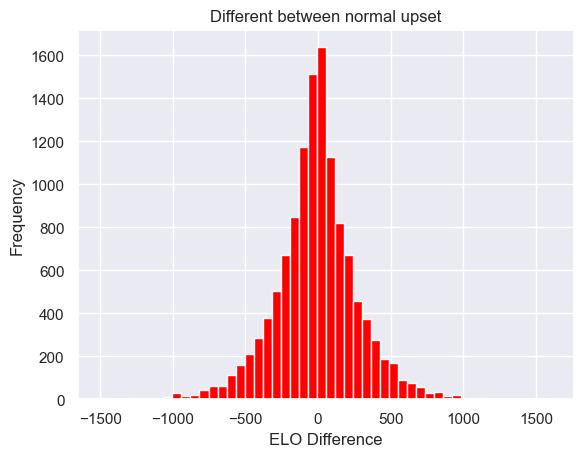

In [25]:
#This still count the upset of player have over 1 elo than the other 
ax = df_upsets["EloDiff"].plot(kind = "hist", bins=50, title = "Different between normal upset", color = 'red')
ax.set_xlabel("ELO Difference")


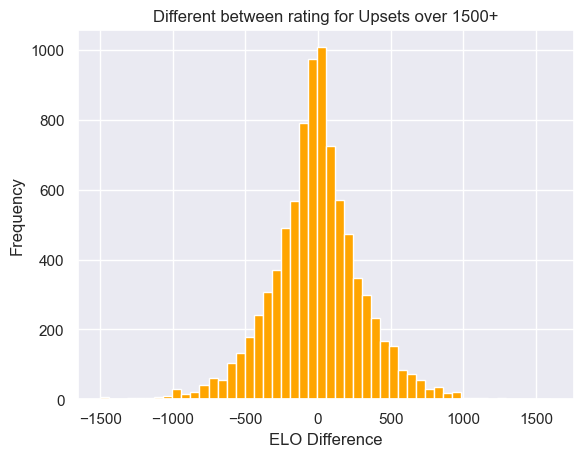

In [26]:
#Check if there is upset over 1500 point different
ax = df_upsets.loc[df_upsets[["white_rating","black_rating"]].max(axis=1) > 1500]["EloDiff"].plot(kind = "hist", bins=50, title = "Different between rating for Upsets over 1500+", color = 'orange')
ax.set_xlabel("ELO Difference")
plt.show()

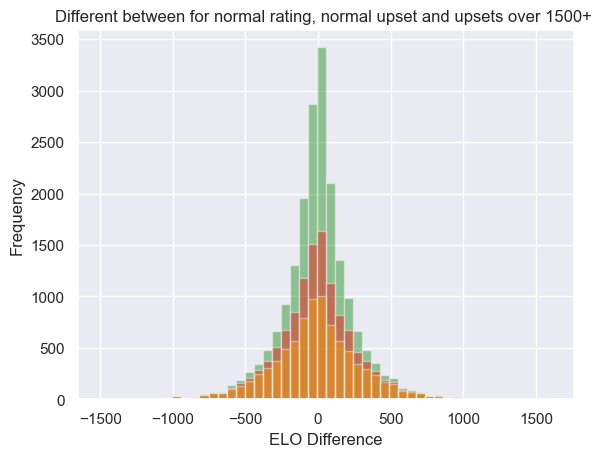

In [27]:
ax = df["EloDiff"].plot(kind = "hist", bins=50, title = "Different between rating", color = 'green', alpha = 0.4)
ax.set_xlabel("ELO Difference")

ax = df_upsets["EloDiff"].plot(kind = "hist", bins=50, title = "Different between rating", color = 'red', alpha = 0.4)
ax.set_xlabel("ELO Difference")


ax = df_upsets.loc[df_upsets[["white_rating","black_rating"]].max(axis=1) > 1500]["EloDiff"].plot(kind = "hist", bins=50, title = "Different between for normal rating, normal upset and upsets over 1500+ ", color = 'orange', alpha = 0.4)
ax.set_xlabel("ELO Difference")
plt.show()


## Observation:
We can see the higher the skill level, the lesser the upset

# DATA CLUSTERING

#### Before we get to data clustering, we need to prepare database again to keep it readable and reliable

Keep only relevant features and serious games where the game lasts at least 10 moves and leave out 'rated' for the purposes of this notebook.

In [28]:
df = df[(df['turns'] > 10)]
df = df[['turns','victory_status','winner','increment_code','white_rating','black_rating','moves','opening_eco','opening_name','opening_ply','time_control']]

In [29]:
#Reducing opening name to two words for grouping ie."Sicilian Defense: Alapin Variation" --> "Sicilian Defense"
df['opening_pref'] = df['opening_name'].apply(lambda x: ' '.join(x.split(' ')[:2]))
df['opening_pref'] = df['opening_pref'].apply(lambda x: x[:-1] if str(x).endswith(':') else x)

#Captures_per_ply measures how aggressively the players exchanged pieces
df['captures_per_ply']= df['moves'].apply(lambda x: str(x).count('x')) / df['turns']

#Get Average Rating of 2 players
df['rating_avg'] = (df['white_rating'] + df['black_rating']) / 2

# get lower rating of two players

def rating_floor(df):
    return min(df['white_rating'],df['black_rating'])
    
df['rating_floor'] = df.apply(rating_floor, axis=1)

### CHECK AVERAGE GAME LENGTH

In [30]:
avg_all = np.mean(df['turns'])
avg_expert= np.mean(df[(df['rating_floor'] >= 2000)]['turns'])

print('Average game length for all games is:', avg_all)
print('Average game length for higher-rated games is:', avg_expert)

Average game length for all games is: 62.382887869682115
Average game length for higher-rated games is: 73.0902348578492


### TURN UPSET INTO COLLUMN

In [31]:
# The winner rating difference is calculated by (winner rating - loser rating).
# If the result is draw, winner_diff is 1/2 negative value.
# Larger negative difference means larger upset. 
def upset(df):
    if df['winner'] == 'white':
        return df['white_rating'] - df['black_rating']
    elif df['winner'] == 'black':
        return df['black_rating'] - df['white_rating']
    else:
        return abs(df['black_rating'] - df['white_rating']) * -.5
    

df['winner_diff'] = df.apply(upset, axis=1)

In [32]:
cluster = df[['turns','opening_eco','opening_pref','opening_ply','captures_per_ply','rating_avg','rating_floor','winner_diff','time_control']] 

Opening ECO and the name of an opening are related, since there are so many variations and transpositions, we can keep both fields. For example, here are some ECO codes of the French Defense:

In [33]:
cluster[['opening_eco','opening_pref']].loc[cluster['opening_pref'] == 'French Defense'].head(10)

opening_eco    opening_pref
11         C02  French Defense
12         C00  French Defense
13         C00  French Defense
60         C00  French Defense
64         C00  French Defense
67         C00  French Defense
72         C02  French Defense
74         C01  French Defense
77         C00  French Defense
79         C00  French Defense

And here are some opening names of ECO code B12

In [34]:
cluster[(cluster['opening_eco'] == 'B12')][['opening_eco','opening_pref']].drop_duplicates()

opening_eco       opening_pref
202           B12  Caro-Kann Defense
18002         B12       Slav Defense

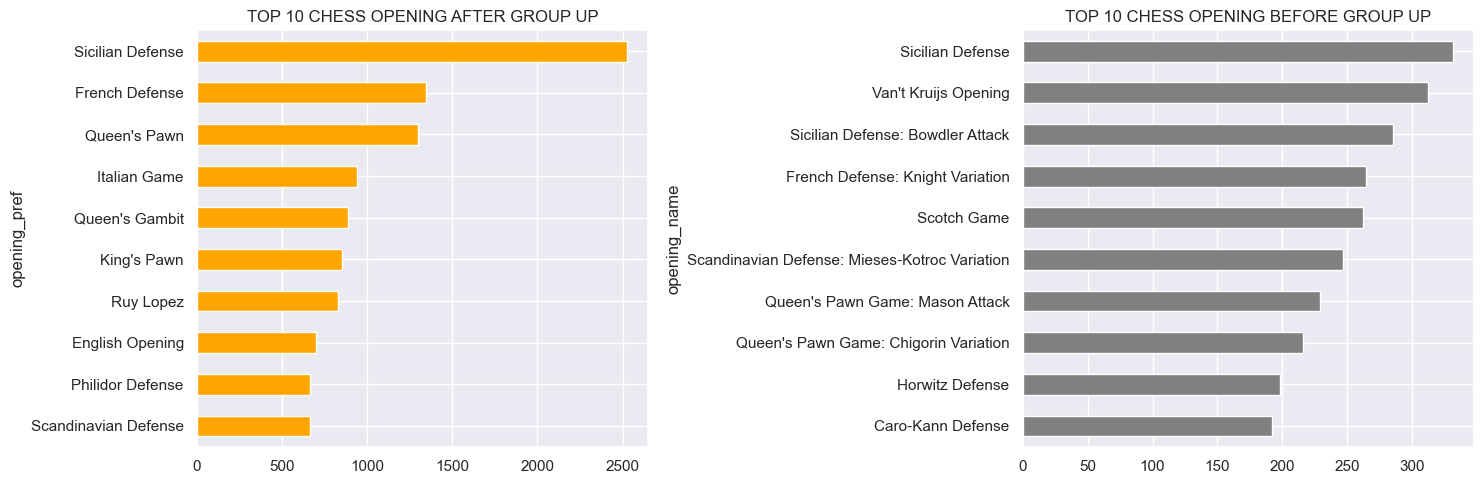

In [35]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the first bar graph on the left subplot
pd.concat([df['opening_name']]).value_counts(ascending=True).tail(10) \
    .plot(kind='barh', ax=ax2, title='TOP 10 CHESS OPENING BEFORE GROUP UP', color='gray')

# Plot the second bar graph on the right subplot
pd.concat([cluster['opening_pref']]).value_counts(ascending=True).tail(10) \
    .plot(kind='barh', ax=ax1, title='TOP 10 CHESS OPENING AFTER GROUP UP', color='orange')


# Adjust the layout for better spacing
plt.tight_layout()

# Show the figure with both subplots
plt.show()

## Observation:
- Now with all the opening with the same type, we can see that Silican Defense is the most prefer with over 2500. We can also see that after we remove the 'rated' columns and only counts from 10 moves up, normal Sicilian Defense is also at the top of the gray graph
+ The reason is:  it can lead to complex and dynamic positions, and it offers both sides opportunities for counterplay. Due to the vast number of variations and subvariations within the Sicilian Defense, it has been extensively studied and analyzed by chess players and theorists, making it one of the most intricate and challenging openings in chess. That is why the Sicilian Defense is a favorite among strong players because
- Philidor Defense, which is the lowest in the left chart, still beat over the highest of the right graph by about 500 games
- Compare to "Before group up", every game has a significant jump in the number of games. 
- The reason is: there are many variations of the opening


In [36]:
!pip install world

In [37]:
encoder = CountEncoder()

cluster[['op_name','op_eco']] = encoder.fit_transform(cluster[['opening_pref','opening_eco']])
cluster.head()

C:\Users\khois\AppData\Local\Temp\ipykernel_19968\954951967.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\khois\AppData\Local\Temp\ipykernel_19968\954951967.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



turns opening_eco         opening_pref  opening_ply  captures_per_ply  \
0     13         D10         Slav Defense            5          0.230769   
1     16         B00  Nimzowitsch Defense            4          0.312500   
2     61         C20          King's Pawn            3          0.278689   
3     61         D02         Queen's Pawn            3          0.229508   
4     95         C41     Philidor Defense            5          0.252632   

   rating_avg  rating_floor  winner_diff  time_control  op_name  op_eco  
0      1345.5          1191        309.0          15.0      231     108  
1      1291.5          1261        -61.0           6.0      213     550  
2      1498.0          1496         -4.0          10.0      850     602  
3      1446.5          1439        -15.0          20.0     1296     422  
4      1496.0          1469         54.0          32.0      666     666

<Axes: title={'center': 'Pearson Correlation of Chess Game Features'}>

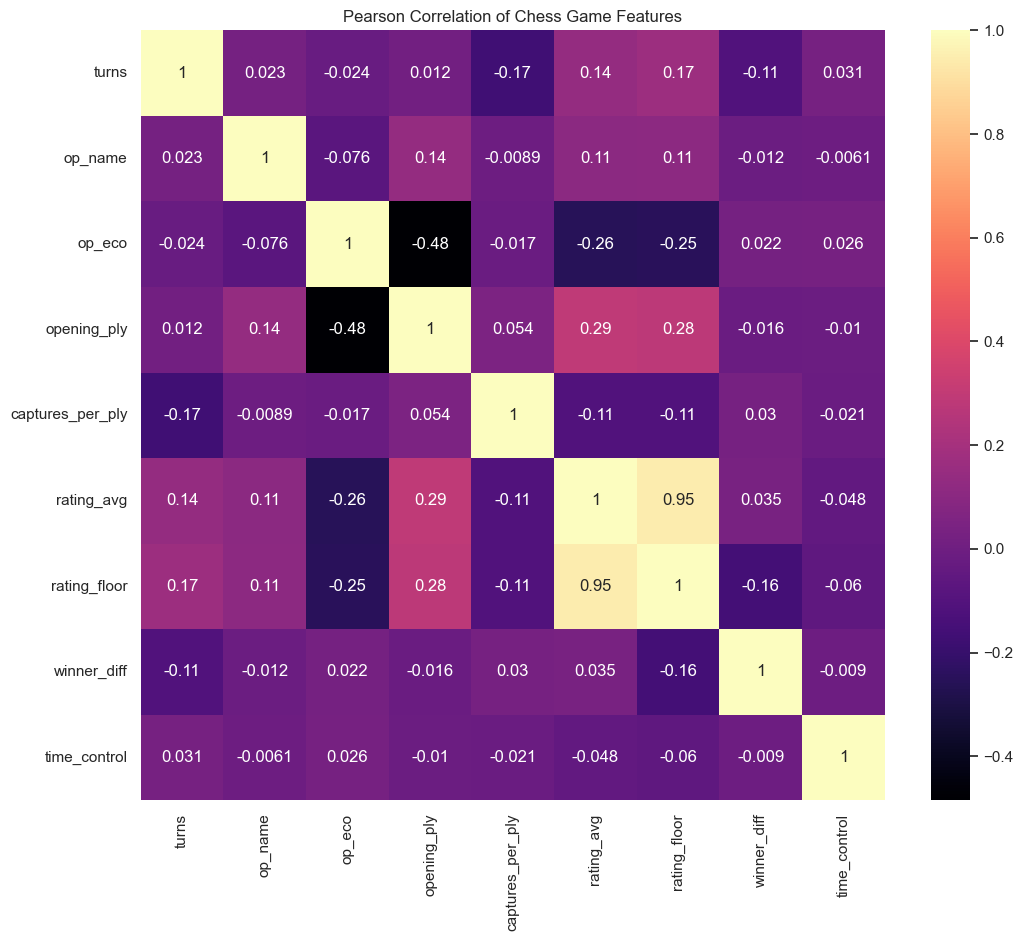

In [38]:
f, ax = plt.subplots(figsize=(12, 10))
plt.title('Pearson Correlation of Chess Game Features')

sns.heatmap(cluster[['turns','op_name','op_eco','opening_ply','captures_per_ply','rating_avg','rating_floor','winner_diff','time_control']].corr(), cmap="magma", annot=True)

#### Correlations:

- rating_floor/avg vs opening_ply- as rating increases, so does the tendency to play more book moves
- rating_floor/avg vs opening_eco- as rating increases, players explore less popular ECO codes
- captures_per_ply vs turns- as game length increases, captures become more spread out
- opening eco is defined by a set series of opening ply

### Scale the feature

In [39]:
scaler = StandardScaler()

features = ['turns','op_name','op_eco','opening_ply','captures_per_ply','rating_avg','rating_floor','winner_diff','time_control']
X = scaler.fit_transform(cluster[features])
X_processed = pd.DataFrame(X, columns = features)

### Find a natural number of groups to assign games.

C:\Users\khois\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\khois\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\khois\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\khois\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\khois\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of

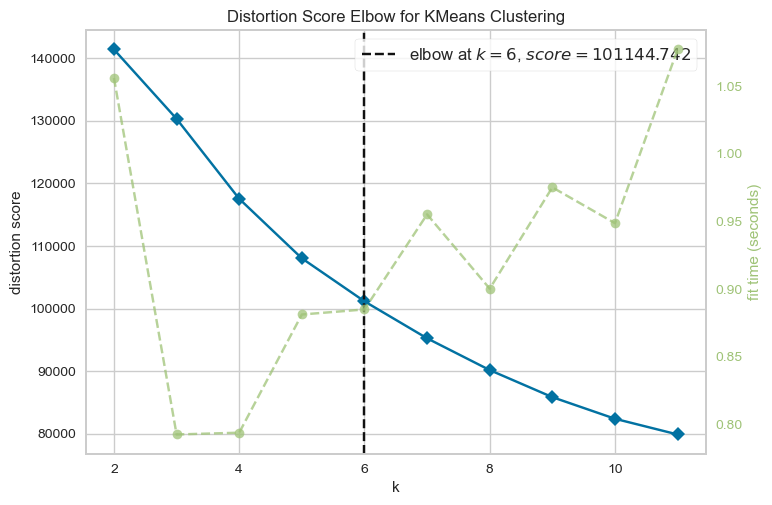

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
from yellowbrick.cluster import KElbowVisualizer
   
kmeans = KMeans(random_state=0)
# Compute cluster centers and predict cluster indices
visualizer = KElbowVisualizer(kmeans, k=(2,12))
visualizer.fit(X_processed)        # Fit the data to the visualizer
visualizer.show()

6 groups seems like a good enough cutoff point. It is very clear that anything more than 7-8 groups is diminishing returns as distortion is not being meaningfully reduced. Now we perform PCA and K-Means clustering to view and find groups within our games. We plot 3 principal components.

In [41]:
pca = PCA(n_components=3,random_state=0)
pca_df = pd.DataFrame(pca.fit_transform(X_processed), columns = ['p1','p2','p3'])
   
kmeans = KMeans(n_clusters=6,random_state=0)

# Compute cluster centers and predict cluster indices

X_clustered = kmeans.fit_predict(pca_df)

C:\Users\khois\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [42]:
# Sanity check

np.unique(X_clustered)

array([0, 1, 2, 3, 4, 5])

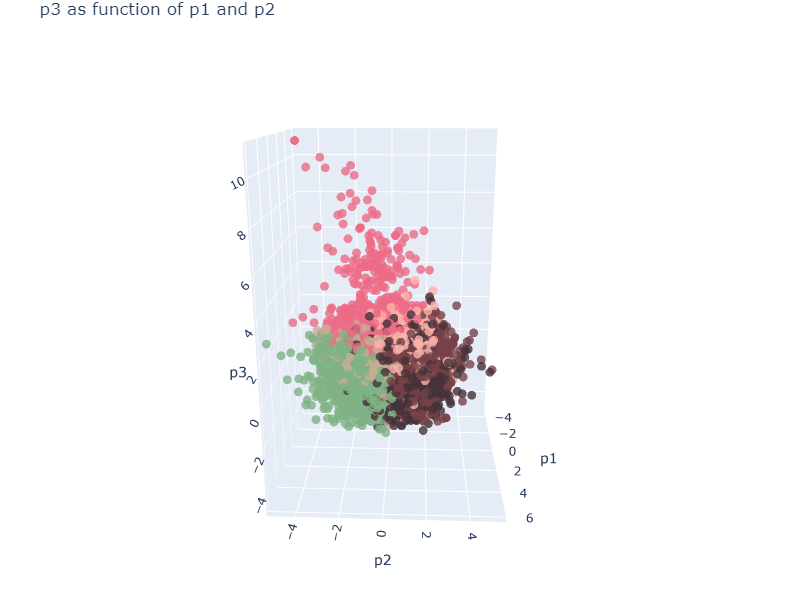

In [43]:
# Plot scatter 3d
def plotly_scatter3d(data, feat1, feat2, feat3, color) :

    df = data # It assigns the dataset provided as the data parameter to a DataFrame variable df.
    x = df[feat1] 
    y = df[feat2] #These lines extract the values of the specified features from the DataFrame, 
    z = df[feat3] #which will be used as the x, y, and z coordinates for the data points in the 3D scatter plot.
                  

    trace1 = go.Scatter3d( x = x, y = y, z = z,                #This section uses Plotly to create a 3D scatter plot. 
                           mode='markers',                     #It defines a scatter trace (trace1) with the specified x, y, and z coordinates 
                           marker=dict( size=5, color = color, #and assigns a color to each data point based on the color parameter.              
                                        colorscale='Viridis',  
                                        opacity=0.8 )
                          )
    data = [trace1]
    camera = dict( up=dict(x=0, y=0, z=1),
                   center=dict(x=0, y=0, z=0.0),
                   eye=dict(x=2.5, y=0.1, z=0.8) )
 
    layout = go.Layout( title= feat3 + " as function of " +     #This section defines the layout for the 3D scatter plot. 
                               feat1 + " and " + feat2 ,        #It includes settings for the title, size, margins, and the camera position for viewing the 3D plot.
                        autosize=False, width=700, height=600,  # The camera position is set to control the view of the plot.             
                        margin=dict( l=15, r=25, b=15, t=30 ) ,
                        scene=dict(camera=camera,
                                   xaxis = dict(title=feat1),
                                   yaxis = dict(title=feat2),
                                   zaxis = dict(title=feat3),                                   
                                  ),
                       )

    fig = go.Figure(data=data, layout=layout) #This line creates a Plotly figure by combining the data trace (trace1) and the defined layout.
    iplot(fig) # This line displays the 3D scatter plot using the Plotly iplot function.

LABEL_COLOR_MAP = {0 : '#fab3a9', 1 : '#c6ad94', 2 : '#7fb285', 3:'#463239', 4:'#764248', 5:'#ed6b86'} 
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]


plotly_scatter3d(pca_df, 'p1', 'p2', 'p3', label_color)

#### Observation:
The plot are melted together. This may be due to the fact that 3 principal components do not sufficiently explain the variance in the original feature space.

In [44]:
cluster.describe().transpose()

count         mean         std     min          25%  \
turns             18969.0    62.382888   32.420046    11.0    39.000000   
opening_ply       18969.0     4.877115    2.797452     1.0     3.000000   
captures_per_ply  18969.0     0.243183    0.061090     0.0     0.206897   
rating_avg        18969.0  1597.292398  260.028257   827.0  1413.000000   
rating_floor      18969.0  1512.570668  269.502026   784.0  1323.000000   
winner_diff       18969.0    81.295139  227.114066 -1121.0   -42.000000   
time_control      18969.0    15.690600   19.158847     2.0    10.000000   
op_name           18969.0   852.675681  767.589495     1.0   231.000000   
op_eco            18969.0   328.396911  272.195480     1.0    81.000000   

                          50%          75%          max  
turns               56.000000    80.000000   349.000000  
opening_ply          4.000000     6.000000    28.000000  
captures_per_ply     0.242424     0.280702     0.566667  
rating_avg        1573.500000  1774.000000  2475.500000  
rating_floor      1500.000000  1696.000000  2474.000000  
winner_diff         42.000000   189.000000  1605.000000  
time_control        10.000000    16.000000   385.000000  
op_name            666.000000  1296.000000  2525.000000  
op_eco             257.000000   574.000000   887.000000

In [46]:
cluster['group'] = X_clustered
cluster['group'].value_counts()

C:\Users\khois\AppData\Local\Temp\ipykernel_19968\2175428683.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



group
4    4615
1    3736
2    3191
0    3169
3    2398
5    1860
Name: count, dtype: int64

In [47]:
cluster0 = cluster[cluster['group']==0]
cluster1 = cluster[cluster['group']==1]
cluster2 = cluster[cluster['group']==2]
cluster3 = cluster[cluster['group']==3]
cluster4 = cluster[cluster['group']==4]
cluster5 = cluster[cluster['group']==5]

In [48]:
cluster0.describe().transpose()

count         mean         std    min          25%  \
turns             3169.0    45.539602   20.718710   11.0    30.000000   
opening_ply       3169.0     3.627958    1.593702    1.0     2.000000   
captures_per_ply  3169.0     0.273610    0.060783    0.0     0.236364   
rating_avg        3169.0  1285.072736  135.582108  827.0  1198.500000   
rating_floor      3169.0  1176.416535  137.339440  784.0  1084.000000   
winner_diff       3169.0   157.666299  248.238558 -685.0    -7.000000   
time_control      3169.0    14.376775    9.504022    2.0    10.000000   
op_name           3169.0   656.937204  584.546011    3.0   198.000000   
op_eco            3169.0   448.644998  246.750006    2.0   231.000000   
group             3169.0     0.000000    0.000000    0.0     0.000000   

                          50%        75%          max  
turns               44.000000    58.0000   144.000000  
opening_ply          3.000000     5.0000    10.000000  
captures_per_ply     0.272727     0.3125     0.566667  
rating_avg        1292.000000  1375.0000  1871.500000  
rating_floor      1180.000000  1276.0000  1671.000000  
winner_diff        118.000000   295.0000  1605.000000  
time_control        10.000000    16.0000   180.000000  
op_name            665.000000   850.0000  2525.000000  
op_eco             507.000000   665.0000   887.000000  
group                0.000000     0.0000     0.000000

Group 0 had lower ratings. The op_eco value is very high. The winner_diff is the highest in all group, meaning this group consists of some skilled players deafeating a lot of low ELO players, with less room for upset. Since captures_per_ply is higher than usual, which means this group have an agressive playstyle.The lower opening_ply, the less knowlege they have about the opening move

In [49]:
cluster1.describe().transpose()

count         mean         std     min          25%  \
turns             3736.0    61.365632   29.169754    11.0    40.000000   
opening_ply       3736.0     2.790150    1.291666     1.0     2.000000   
captures_per_ply  3736.0     0.221160    0.057075     0.0     0.192211   
rating_avg        3736.0  1523.634234  141.387752  1029.0  1430.875000   
rating_floor      3736.0  1443.081103  138.699143   950.0  1354.000000   
winner_diff       3736.0   100.757495  211.889412  -852.0   -25.000000   
time_control      3736.0    12.990899    6.830158     3.0    10.000000   
op_name           3736.0   669.309154  582.957457     1.0   167.000000   
op_eco            3736.0   607.586188  221.199239    20.0   530.000000   
group             3736.0     1.000000    0.000000     1.0     1.000000   

                          50%          75%          max  
turns               58.000000    80.000000   190.000000  
opening_ply          3.000000     4.000000     8.000000  
captures_per_ply     0.226804     0.258065     0.396552  
rating_avg        1519.500000  1611.625000  2067.500000  
rating_floor      1455.000000  1530.000000  1912.000000  
winner_diff         54.000000   200.250000  1237.000000  
time_control        10.000000    15.000000    70.000000  
op_name            665.000000  1296.000000  2525.000000  
op_eco             665.000000   798.000000   887.000000  
group                1.000000     1.000000     1.000000

Group 1 games have high ECO averages, with lowest mean of opening_ply, meaning games moving quickly away from known openings. Reviewing counts, it looks like many French Defense (C00) and unusual openings (A00).

In [50]:
cluster1['opening_eco'].value_counts()[:5]

opening_eco
A00    623
C00    447
D00    326
A40    306
C20    303
Name: count, dtype: int64

In [51]:
cluster2.describe().transpose()

count         mean         std     min          25%  \
turns             3191.0    81.280163   37.404631    11.0    54.000000   
opening_ply       3191.0     4.093074    1.759823     1.0     3.000000   
captures_per_ply  3191.0     0.208444    0.050023     0.0     0.181818   
rating_avg        3191.0  1861.098558  157.459927  1500.0  1745.250000   
rating_floor      3191.0  1798.362582  155.908593  1453.0  1692.000000   
winner_diff       3191.0    43.376058  166.342108  -574.0   -50.000000   
time_control      3191.0    13.526794    8.881975     3.0    10.000000   
op_name           3191.0   800.300533  738.188950     1.0   220.000000   
op_eco            3191.0   330.981824  248.295672     1.0   118.000000   
group             3191.0     2.000000    0.000000     2.0     2.000000   

                          50%      75%          max  
turns               77.000000   106.00   349.000000  
opening_ply          4.000000     5.00    13.000000  
captures_per_ply     0.212121     0.24     0.368421  
rating_avg        1841.500000  1958.50  2448.000000  
rating_floor      1787.000000  1885.00  2393.000000  
winner_diff         15.000000   123.50  1121.000000  
time_control        10.000000    15.00   109.000000  
op_name            665.000000  1296.00  2525.000000  
op_eco             262.000000   550.00   887.000000  
group                2.000000     2.00     2.000000

Group 2 has high-rated player like group 3. The amount of turns per game is larger, and winner-diff is lower. More games are drawn, as draws appear in higher frequency as rating increases. Captures_per_ply is lower so this group have an patient way of playing the game

In [52]:
cluster3.describe().transpose()

count         mean         std        min          25%  \
turns             2398.0    65.748540   28.894911    11.0000    45.000000   
opening_ply       2398.0     8.952877    3.208489     2.0000     7.000000   
captures_per_ply  2398.0     0.241093    0.050661     0.0625     0.208333   
rating_avg        2398.0  1927.323186  171.596578  1451.5000  1808.125000   
rating_floor      2398.0  1851.695163  173.966150  1372.0000  1731.000000   
winner_diff       2398.0    54.827565  202.310321 -1008.0000   -52.000000   
time_control      2398.0    15.650125   11.915771     3.0000    10.000000   
op_name           2398.0  1270.294412  957.077445     2.0000   350.000000   
op_eco            2398.0    73.084237   91.298616     1.0000    15.000000   
group             2398.0     3.000000    0.000000     3.0000     3.000000   

                          50%          75%          max  
turns               61.000000    82.000000   185.000000  
opening_ply          9.000000    11.000000    28.000000  
captures_per_ply     0.240253     0.270833     0.463415  
rating_avg        1911.500000  2042.500000  2475.500000  
rating_floor      1837.000000  1963.000000  2474.000000  
winner_diff         29.000000   147.750000  1076.000000  
time_control        10.000000    17.000000    94.000000  
op_name            889.000000  2525.000000  2525.000000  
op_eco              32.500000   101.000000   690.000000  
group                3.000000     3.000000     3.000000

Group 3 has high-rated player similar to group 2. However, games remain in the the opening for longer with higher opening_ply, as players may have more knowledge of opening theory. Op_name is higher than the other groups, which shows preference for more popular openings.

In [53]:
cluster4.describe().transpose()

count         mean         std      min          25%  \
turns             4615.0    48.169881   19.646137    11.00    34.000000   
opening_ply       4615.0     5.972698    2.252320     1.00     4.000000   
captures_per_ply  4615.0     0.274928    0.055502     0.04     0.240741   
rating_avg        4615.0  1576.990358  145.431019  1092.50  1478.500000   
rating_floor      4615.0  1486.747779  140.750587   978.00  1393.000000   
winner_diff       4615.0   127.123510  232.029443  -654.00   -16.000000   
time_control      4615.0    13.129577    7.225432     3.00    10.000000   
op_name           4615.0   913.718310  794.513038     2.00   278.000000   
op_eco            4615.0   170.180282  149.932305     1.00    59.000000   
group             4615.0     4.000000    0.000000     4.00     4.000000   

                       50%          75%          max  
turns               47.000    60.000000   121.000000  
opening_ply          6.000     7.000000    18.000000  
captures_per_ply     0.275     0.309091     0.521739  
rating_avg        1566.500  1672.500000  2168.000000  
rating_floor      1500.000  1577.000000  1959.000000  
winner_diff         74.000   230.000000  1605.000000  
time_control        10.000    15.000000   109.000000  
op_name            828.000   941.000000  2525.000000  
op_eco             120.000   257.000000   798.000000  
group                4.000     4.000000     4.000000

Group 4 is the most similar to the general population across the board, with overall mid rating_avg and rating_floor, which is around 1500. Though this group is agressive since the captures_per_ply is higher than usual

In [54]:
cluster5.describe().transpose()

count         mean         std     min          25%  \
turns             1860.0    91.629032   37.112437    11.0    66.000000   
opening_ply       1860.0     4.569355    2.004574     1.0     3.000000   
captures_per_ply  1860.0     0.219103    0.047712     0.0     0.195265   
rating_avg        1860.0  1449.488978  159.626978   981.0  1347.250000   
rating_floor      1860.0  1361.428495  158.080943   789.0  1259.000000   
winner_diff       1860.0  -102.447043  210.071719 -1121.0  -204.250000   
time_control      1860.0    33.470430   51.878356     6.0    10.000000   
op_name           1860.0   954.460753  825.566553     3.0   278.000000   
op_eco            1860.0   280.033333  227.367399     1.0    81.000000   
group             1860.0     5.000000    0.000000     5.0     5.000000   

                          50%      75%          max  
turns               92.000000   116.00   259.000000  
opening_ply          4.000000     6.00    13.000000  
captures_per_ply     0.222222     0.25     0.369565  
rating_avg        1461.000000  1548.00  2146.000000  
rating_floor      1389.000000  1495.00  2069.000000  
winner_diff        -69.750000     8.25   617.000000  
time_control        15.000000    30.00   385.000000  
op_name            828.000000  1296.00  2525.000000  
op_eco             219.000000   422.00   887.000000  
group                5.000000     5.00     5.000000

Group 5 is the underdog group. Winner_diff is negative, meaning lower-rated players are defeating higher-rated players. These games have the longest time_control by far, with games averaging more than 30 minutes each.

## GAME OUTCOME PREDICTION

In this code:

- We load the chess dataset into a DataFrame.

- We define the features (X) and target (y).

- Categorical features like 'Opening Name' are converted into numerical features using one-hot encoding.

- The dataset is split into a training set and a testing set for model evaluation.

- We use a Random Forest Classifier as the machine learning model.

- The model is trained on the training data and used to make predictions on the test data.

- The model's performance is evaluated using accuracy, precision, recall, and F1-score.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the features (X) and target (y)

X = df[['white_rating', 'black_rating', 'opening_name']]
y = df['winner']  # Assuming 'Result' contains 'White win', 'Black win', 'Draw'

# Convert categorical features to numerical using one-hot encoding
X = pd.get_dummies(X, columns=['opening_name'], drop_first=True)

# Split the dataset into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a Random Forest Classifier
clf = RandomForestClassifier()

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')



In [ ]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: Accuracy measures the proportion of correct predictions made by the model. In this case, an accuracy of 0.62 means the model is correct in its predictions 60% of the time. Whether this is good or not depends on the specific problem. In some contexts, 62% accuracy might be considered good, while in others, it might be insufficient.

Precision: Precision is a measure of the true positive rate among all predicted positives. A precision of 0.61 indicates that 61% of the predicted positive outcomes were correct. 

Recall: Recall measures the true positive rate among all actual positives. A recall of 0.62 suggests that the model correctly identified 62% of the actual positive outcomes. It's essential when it's crucial to find all the positive cases.

F1 Score: The F1 score is the harmonic mean of precision and recall, providing a balance between the two. A value of 0.61 means a balanced trade-off between precision and recall.